In [1]:
import swarmrl as srl

from swarmrl.observables.top_down_image import TopDownImage
from jax import numpy as np
import matplotlib.pyplot as plt
from swarmrl.components import Colloid
import open3d as o3d
import logging
import flax.linen as nn
from swarmrl.tasks.dummy_task import DummyTask
import optax
from swarmrl.actions.mpi_action import MPIAction
from swarmrl.engine.gaurav_sim import *
from swarmrl.trainers.global_continuous_trainer import GlobalContinuousTrainer as Trainer
import pint


2024-09-12 15:14:12.074955: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
logging.basicConfig(level=logging.WARNING)


resolution=1280
number_of_gaussians=2
action_dimension=8
rafts = o3d.io.read_triangle_mesh("coloured_rafts.ply")

obs = TopDownImage(
    np.array([10000.0, 10000.0, 0.1]), image_resolution=np.array([resolution]*2), particle_type=0, custom_mesh=rafts, is_2D=True, save_images=True
)
task = DummyTask()


class ActoCriticNet(nn.Module):
    """A simple dense model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(1, 1))(x)
        x = x.flatten()
        y = nn.Dense(features=2)(x)
        x = nn.Dense(features=2)(x)
        x = nn.relu(x)
        y = nn.relu(y)

        y = nn.Dense(features=12)(y)
        x = nn.Dense(features=12)(x)
        x = nn.relu(x)
        y = nn.relu(y)
        y = nn.Dense(features=1)(x)  # Critic
        x = nn.Dense(features=number_of_gaussians*action_dimension*2)(x)  # Actor
        #pass output designed for variance through relu function (last number_of_gaussians*action_dimension)
        x = x.at[number_of_gaussians * action_dimension:].set(nn.relu(x.at[number_of_gaussians * action_dimension:].get()))

        return x, y


exploration_policy = srl.exploration_policies.RandomExploration(probability=0.0) # check this

# Define a sampling_strategy
sampling_strategy = srl.sampling_strategies.ContinuousGaussianDistribution()

# Value function to use
value_function = srl.value_functions.GlobalExpectedReturns(gamma=0.1, standardize=True)

# Define the model
actor_critic = ActoCriticNet()



[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x120e0f800010 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


In [3]:
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Define parameters in SI units
params = GauravSimParams(
            ureg=ureg,
            box_length=Q_(10000, "micrometer"),
            time_step=Q_(1e-3, "second"),
            time_slice=Q_(1, "second"),
            snapshot_interval=Q_(0.002, "second"),
            raft_radius=Q_(150, "micrometer"),
            raft_repulsion_strength=Q_(1e-7, "newton"),
            dynamic_viscosity=Q_(1e-3, "Pa * s"),
            fluid_density=Q_(1000, "kg / m**3"),
            lubrication_threshold=Q_(15, "micrometer"),
            magnetic_constant=Q_(4 * np.pi * 1e-7, "newton /ampere**2"),
            capillary_force_data_path=pathlib.Path(
                "/work/clohrmann/mpi_collab/capillaryForceAndTorque_sym6"
            ),  # TODO
        )

# Initialize the simulation system
system_runner = GauravSim(params=params, out_folder="./", with_precalc_capillary=True,save_h5=True)
mag_mom = Q_(1e-8, "ampere * meter**2")
for i in range(20):
    system_runner.add_colloids(pos = [np.random.rand()*10000,np.random.rand()*10000, 0]* ureg.micrometer, alpha = np.random.rand()*2*np.pi, magnetic_moment = 1E-8* ureg.ampere * ureg.meter**2)



In [4]:

network = srl.networks.ContinuousFlaxModel(
    flax_model=actor_critic,
    optimizer=optax.adam(learning_rate=0.01),
    input_shape=(1,resolution,resolution,1), #1 are required for CNN
    sampling_strategy=sampling_strategy,
    exploration_policy=exploration_policy,
    number_of_gaussians=number_of_gaussians,
    action_dimension=action_dimension,
)
loss = srl.losses.GlobalPolicyGradientLoss(value_function=value_function)

protocol = srl.agents.MPIActorCriticAgent(
    particle_type=0,
    network=network,
    task=task,
    observable=obs,
    loss=loss,
)
rl_trainer = Trainer([protocol])

Output()

self.current_action=MPIAction(amplitudes=array([2.1666469e-07, 5.9805785e-07], dtype=float32), 
frequencies=array([0.00074712, 0.00121627], dtype=float32), phases=array([0.00088242, 0.        ], dtype=float32), 
offsets=array([0., 0.], dtype=float32))

KeyboardInterrupt: 

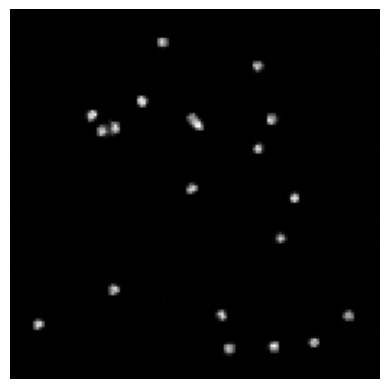

In [5]:
rl_trainer.perform_rl_training(system_runner, 20, 100)